In [1]:
%load_ext autoreload
%autoreload 2

# Data Augmentation in Pytorch EO

Data augmentation is a key technique used in computer vision. It helps neural networks to learn useful representations and generalize better to unseen samples. In this tutorial we show how to do data augmentation in Pytorch EO with the EuroSAT dataset.

In [2]:
import os
from pytorch_eo.utils import download_url, unzip_file
from pathlib import Path

path = Path('data')
os.makedirs(path, exist_ok=True)

url = "http://madm.dfki.de/files/sentinel/EuroSAT.zip"
compressed_data_filename = 'EuroSAT.zip'
compressed_data_path = path / compressed_data_filename
download_url(url, compressed_data_path)
unzip_file(compressed_data_path, path, msg="extracting data ...")

extracting data ...: 100%|██████████| 27011/27011 [00:02<00:00, 10079.09it/s]


In [3]:
data_folder = '2750'
uncompressed_data_path = path / data_folder
classes = sorted(os.listdir(uncompressed_data_path))
classes

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [4]:
import pandas as pd

images, labels = [], []
for ix, label in enumerate(classes):
    _images = os.listdir(uncompressed_data_path / label)
    images += [str(uncompressed_data_path /
                label / img) for img in _images]
    labels += [ix]*len(_images)

df = pd.DataFrame({'image': images, 'label': labels})

df.sample(5)

,image,label
23136,data/2750/River/River_2042.jpg,8
10992,data/2750/Highway/Highway_496.jpg,3
10958,data/2750/Highway/Highway_153.jpg,3
23252,data/2750/River/River_2339.jpg,8
6321,data/2750/HerbaceousVegetation/HerbaceousVeget...,2


In [39]:
from pytorch_eo.datasets import RGBImageDataset
from pytorch_eo.datasets import ConcatDataset

images_ds = RGBImageDataset(images)
ds = ConcatDataset({'image': images_ds, 'label': labels}) # no transforms

len(ds)

27000

If we query for the same image, we will get the same version.

In [40]:
import matplotlib.pyplot as plt 

def plot_sample(ds, ix=10, image_key='image'):
	x = 5
	fig = plt.figure(figsize=(2*x, 5))
	for i in range(x):
		sample = ds[ix]
		image, label = sample[image_key], sample['label']
		ax = plt.subplot(1, x, i+1)
		ax.imshow(image)
		ax.set_title(classes[label])
	plt.tight_layout()
	plt.show()

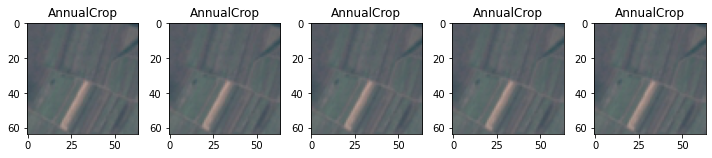

In [41]:
plot_sample(ds)

By providing transforms, we can have more variety in our data. By default, `PytorchEO` support data augmentation with `albumentations`.

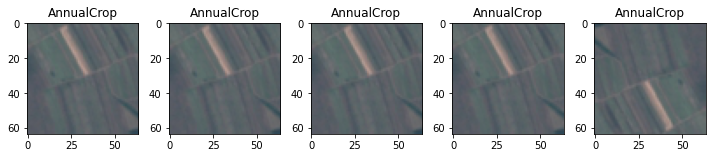

In [49]:
import albumentations as A

trans = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5)
])

ds = ConcatDataset({'image': images_ds, 'label': labels}, trans) 

plot_sample(ds)

If you use a different key for the image field, make sure to tell the dataset (this is how albumentation works).

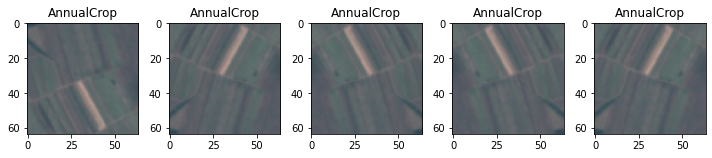

In [57]:
trans = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5)
], additional_targets={'abc': 'image'})

ds = ConcatDataset({'abc': images_ds, 'label': labels}, trans, image_key='abc') 

plot_sample(ds, image_key='abc')

Finally, you can customize the transformation pipeline by overriding the `apply_transforms` method.

In [70]:
import random 
import numpy as np

def my_transforms(data):
	if random.random() > 0.5:
		data['image'] = np.fliplr(data['image'])
	return data

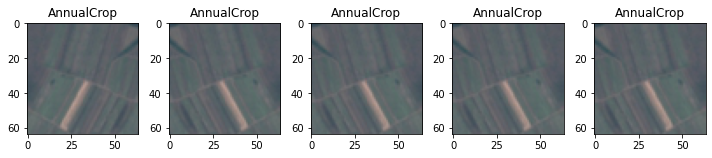

In [71]:
ds = ConcatDataset({'image': images_ds, 'label': labels})

ds.apply_transforms = my_transforms

plot_sample(ds)